# Analysis of Messenger chats

In this notebook, I will be analyzing my **facebook messenger chat data**.

I will create visualizations of the information that can be obtained from that textual chat, and we will play around with this data.

## Obtaining the data

* You can obtain your own chat data by logging into Facebook and going to Settings and Privacy --> Settings --> Your Facebook Information --> Download Your Information.

* Once you are there, select the date range of interest (includes first date, excludes last date), JSON format, and Low Media Quality (we will only work with textual data). Then **De**select All and click on the checkbox next to Messages.

* Then click Create File. This data should be available within the next 20 - 25 minutes. If you return to this page at that time and your request is still pending, cancel the request and make a new request.

Once the file is created, you will have a few days during which you can download this data. Note that your file size will vary depending on the amount of messages that you have been sending and receiving (including messages in group chats).

If you have a poor internet connection, you might have difficulties downloading a huge file in one go, so you might end up breaking your data range into multiple time segments and downloading them separately. Do not worry if this is what you do - I will demonstrate a script that combines your data into a single JSON file per conversation.

## Saving the data

When you download the data from facebook, you obtain a ZIP file containing a ***messages*** folder. Unzip the ***messages*** folder and place it into your project directory (the directory where you will save your Python files).

The ***messages*** folder could contain a few other subdirectories, but we are only interested in the ***inbox*** folder (***filtered_threads*** contains any conversations that you have muted or ignored, you could pull them into the ***inbox*** folder if you would like to analyze them).

Inside of ***messages*** you will find a folder corresponding to each individual conversation and each group chat that you are in. Each of these folders contains other folders, such as ***files***, ***gifs***, ***photos***, and ***videos***, as well as a set of JSON files (or maybe just one JSON file) called **message_1**. Of course, if there are multiple such files, they will be labeled with the according number.

The **message_\*** files are the files that interest us. They contain the actual chat messages with meta data about them. We will preprocess these data files.

But first, let's gather each chat into a single JSON file. The messages are arranged in reverse chronological order - the newest messages appear first. The files are likewise arranged in reverse chronological order.

Each file starts with a list of **participants**, followed by a list of **messages**, and closed by meta data about the chat that it represents. We want to iterate through the messages files of each conversation and create a new file out of those messages.

In [1]:
import os                      # We will use this to search through the directory tree
import json                    # We will use this to open and manipulate JSON files

In [12]:
rootDir = '.'
for dirName, subdirList, fileList in os.walk(rootDir):
    
    counter = 0    # Ensures that aggregate message.json file is added only once per directory containing message_ files
    
    for fname in fileList:
        if fname[:8] == 'message_':                        # Working with each message_(number) file in directory
            
                                                               # Get data from the message_ file
            with open(dirName + '/' + fname) as source:
                chat_file = json.load(source)
            source.close()
            
                                                               # Only if first message_ in directory, initiate message.json file
            if counter == 0:
                with open(dirName + '/message.json', 'w') as dest:
                    json.dump({'participants': chat_file['participants'],
                               'messages': [],
                               'title': chat_file['title'],
                               'thread_type': chat_file['thread_type']}, dest)
                dest.close()
            counter += 1

                                                                # Open message.json file of directory
            with open(dirName + '/message.json') as dest:
                destination = json.load(dest)
            dest.close()
            
                                                                # Extend messages list of message.json JSON object
            messages = destination['messages']
            messages.extend(chat_file['messages'])
            
                                                                # Place the JSON object into message.json file of directory
            with open(dirName + '/message.json', 'w') as dest:
                json.dump(destination, dest, indent=2)
            dest.close()

The code above creates a **message.json** file for each conversation directory. It iterates through the directory tree, visiting each directory `dirName` and searching through the files in the `fileList` of the directory.

If the name of a file is of the form **message_**(number)**.json**, then this is a chat data JSON file. The list of the `messages` in this file is concatenated with the list of messages in the **message.json** file of the directory. This file is created once the first message file is encountered during the directory tree traversal. When it is generated, a copy of the participants list is placed at the top of the file, followed by an empty messages list that is to be extended by the data in the message files.

Here I took advantage of the reverse chronological ordering of the chat messages in the JSON files - since the newest messages are at the top of each file, and since the **message_**(number)**.json** files are numbered in reverse chronological order, the tree traversal will visit the newest files first, and extend the `messages` list with successively older messages. Therefore, the reverse chronological ordering is maintained in the **message.json** file. This file is created for each directory that contains **message_**(number)**.json** files, corresponding to an entire conversation.


Before we begin exploring the data, I will demonstrate how to combine files pertaining to the same conversation from separate folders, in the case that you downloaded data from facebook in multiple batches by time interval. In order to do this, you must first save each downloaded batch of conversation folders in directories called ***message1***, ***message2***, etc, labeled in reverse chronological order.

In [13]:
conversations = {}                      # Dictionary to store names of conversations grouped by downloads

download_chunks = os.listdir('.')       # List of names of subdirectories of the root directory of the project

                                        # Populate conversations dictionary with names of messages in download
for chunk in download_chunks:
    if chunk[:8] == 'messages':
        conversations[chunk] = os.listdir('./' + chunk + '/inbox')

                                        # Create conversations directory in root directory of project
if not os.path.exists('./conversations/'):
    os.makedirs('./conversations')

In [14]:
import shutil                                   # We will use this to copy/paste files

                                                # For each download
for chunk, convos in conversations.items():
                                                # For each conversation folder in the download
    for convo in convos:
                                                # If conversation not in conversations folder, copy file into conversations folder
        if not os.path.exists('./conversations/' + convo + '.json'):
            shutil.copy('./' + chunk + '/inbox/' + convo + '/message.json', './conversations/' + convo + '.json')
                                                # If later part of conversation is already in conversations folder, extend with these earlier messages
        else:
            with open('./' + chunk + '/inbox/' + convo + '/message.json') as source:
                chat_file = json.load(source)
            source.close()
            with open('./conversations/' + convo + '.json') as dest:
                destination = json.load(dest)
            dest.close()
            
            messages = destination['messages']
            messages.extend(chat_file['messages'])
                      
            with open('./conversations/' + convo + '.json', 'w') as dest:
                json.dump(destination, dest, indent=2)
            dest.close()

In the first codeblock above I created the `conversations` dictionary to store the list of names of conversations that are found in each download. I also initiated the `conversations` folder in the root directory of the project. This folder will store a single JSON file for each conversation containing the list of participants as well as all of the messages of that conversation (gathered from all of the downloads) in the appropriate order.

In the second codeblock, I iterate through the `conversations` dictionary, download by download. For each conversation in the download (`message.json` file that we have created earlier), I check if this conversation is already in the `conversations` folder. If not, I create a copy of the file in the conversations folder. Otherwise, by virtue of the reverse chronological order labeling of the message files, I know that I have found an earlier segment of the conversation, so I can now simply extend the appropriate JSON file in the `conversations` folder with the older messages.

## Preprocessing the messages

We can now preprocess the JSON files that are stored in the `conversations` folder.

First we want to get rid of the `is_unsent` elements of the each message, because this is not providing us with any useful information. We will define a function that will do this.

In [23]:
def remove_is_unsent(message):
    if 'is_unsent' in message.keys():
        del message['is_unsent']

We also want to create a function that will convert the facebook messenger timestamps to Python timestamps.

In [25]:
import datetime

def timestamp_converter(message):
    if type(message['timestamp_ms']) != str:
        message['timestamp_ms'] = str(datetime.datetime.fromtimestamp(message['timestamp_ms']/1000.0))

We will replace content of the message if it is a URL or not of the `Generic` type.

In [27]:
import re

def replace_message_content(message):
    if 'type' in message.keys():
        if message['type'] != 'Generic':
            message['content'] == 'Non-textual'
    
    if 'content' in message.keys():
        if re.search('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))', message['content']):
            message['content'] = 'URL'

We will delete the data from the file that we will not need for our analysis.

In [28]:
def delete_extra_data(message):
    if 'share' in message.keys():
        del message['share']
    if 'photos' in message.keys():
        del message['photos']
    
    if 'type' in message.keys():
        del message['type']

We will add the name of the conversation to which the message pertains, so that when we analyze the data, we can filter it by conversation. This is necessary because you might be sharing multiple conversations with a facebook friend, and the messages can be interlaced.

In [527]:
def add_conversation_name(conversation, message):
    message['conversation'] = conversation

Now we will create a `preprocessing` function that will iterate through the messages of a conversation and apply the preprocessing functions to the message. We will then iterate through the conversations in our `conversations` folder and apply the preprocessing function to each conversation.

In [528]:
def preprocessing(conversation):
    with open('./conversations/' + conversation) as f:
        chat_file = json.load(f)
    f.close()
    
    for message in chat_file['messages']:
        remove_is_unsent(message)
        timestamp_converter(message)
        replace_message_content(message)
        delete_extra_data(message)
        add_conversation_name(conversation, message)

    with open('./conversations/' + conversation, 'w') as f:
        json.dump(chat_file, f, indent= 2)
    f.close()

In [529]:
chats = os.listdir('./conversations')

for conversation in chats:
    preprocessing(conversation)

## Preprocessing the participants

First of all, if any member of a group chat that you have been involved in has left the chat by the time when you downloaded your data, the member will not be displayed in the `participants` list at the top of the conversation file. Therefore we must scan through the messages of each group conversation to ensure that all of the members are listed as participants.

In [34]:
for conversation in chats:
    with open('./conversations/' + conversation) as f:
        chat_file = json.load(f)
    f.close()
    
    if chat_file['thread_type'] != 'Regular':
        for message in chat_file['messages']:
            member = {'name': message['sender_name']}
            if member not in chat_file['participants']:
                chat_file['participants'].append(member)
    
    with open('./conversations/' + conversation, 'w') as f:
        json.dump(chat_file, f, indent= 2)
    f.close()

Then we create a `participants.json` file and populate it with a dictionary of participants from across the different conversations. This dictionary, called `participants` will later be populated with information about each participant. If certain contacts have appeared in multiple conversations (for instance in group chats), they will only be counted once.

In [35]:
participants = {}                        # Stores data corresponding to each participant

for conversation in chats:
    with open('./conversations/' + conversation) as f:
        chat_file = json.load(f)
    f.close()
    
    for member in chat_file['participants']:
        name = member['name']
                                                        # If name of participant not encountered before, add to participants
        if name not in participants.keys():
            participants[name] = {}

with open('./participants.json', 'w') as chatters:
    json.dump(participants, chatters, indent= 2)
chatters.close()

The participants in the `participant_names` dictionary are keyed by their names, so that it is easy to find the participant in the `participants.json` file.

Now we want to add information about each participant to the `participants.json` file. We only run this code once.

In [ ]:
with open('./participants.json') as chatters:
    participants = json.load(chatters)
chatters.close()

for member in participants.keys():
    if member not in participants.keys():
        participants[member]['major'] = input('(%s)   Major: ' % member)                # math, cs, finance, physics
        participants[member]['met me at'] = input('(%s)   Met me at: ' % member)           # brooklyn tech, baruch, stony brook
        participants[member]['met me semester'] = input('(%s)   Met me semester: ' % member)     # 1, 3, 4
        participants[member]['lives in'] = input('(%s)   Lives in: ' % member)              # NYC, LI, International, n/a
        participants[member]['entered college'] = input('(%s)   Entered college in: ' % member)      # 2015, 2016, 2017

with open('./participants.json', 'w') as chatters:
    json.dump(participants, chatters, indent= 2)
chatters.close()

## Analyzing the data

We can now begin to analyze our data. First we will create a function that will create a `pandas` DataFrame object representing the messages of the conversation. This object will represent additional information about each message, relating to the timestamp and the sender of the message. For the message sender information, we will be using the `participants` dictionary from the `participants.json` file.

In [2]:
import pandas as pd

In [3]:
with open('./participants.json') as p:
    participants = json.load(p)
p.close()

def create_dataframe(conversation):
    with open('./conversations/' + conversation) as f:
        chat_file = json.load(f)
    f.close()

    mess = chat_file['messages']

    df = pd.DataFrame(mess)

    if 'sticker' in df.keys():
        del df['sticker']
    if 'videos' in df.keys():
        del df['videos']
    if 'files' in df.keys():
        del df['files']
    if 'ip' in df.keys():
        del df['ip']
    if 'gifs' in df.keys():
        del df['gifs']
    if 'call_duration' in df.keys():
        del df['call_duration']
    if 'missed' in df.keys():
        del df['missed']
    if 'audio_files' in df.keys():
        del df['audio_files']
    if 'users' in df.keys():
        del df['users']

    df['year'] = pd.DatetimeIndex(df['timestamp_ms']).year
    df['month'] = pd.DatetimeIndex(df['timestamp_ms']).month
    df['day'] = pd.DatetimeIndex(df['timestamp_ms']).dayofweek
    
    df['date'] = pd.DatetimeIndex(df['timestamp_ms']).date
    df['time'] = pd.DatetimeIndex(df['timestamp_ms']).time

    df['major'] = df['sender_name'].apply(lambda sender: participants[sender]['major'])
    df['meeting place'] = df['sender_name'].apply(lambda sender: participants[sender]['met me at'])
    df['meeting semester'] = df['sender_name'].apply(lambda sender: participants[sender]['met me semester'])
    df['meeting'] = df['meeting place'] + ' ' + df['meeting semester']
    df['lives in'] = df['sender_name'].apply(lambda sender: participants[sender]['lives in'])
    df['entered_college'] = df['sender_name'].apply(lambda sender: participants[sender]['entered college'])
    
    return df

Now we can create a new dataframe that concatenates the dataframes for each of the conversation files.

In [4]:
df = pd.DataFrame()

chats = os.listdir('./conversations')

for conversation in chats:
    convo_df = create_dataframe(conversation)
    df = pd.concat([df, convo_df])

Now we also want to run some basic **natural language processing** on the message texts. For instance, let us find the sentiment of each message. We will store it in a separate `sentiment` column in the dataframe.

In [5]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

nltk.download('vader_lexicon')

sentiment_analyzer = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Denis\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [6]:
def get_polarity(text):                                                 # Get the compound score from text
    if (type(text) == str):                                             # Compound score is returned only when the input is a string (input is the message)
        return sentiment_analyzer.polarity_scores(text)['compound']     # Compound score ranges from -1 to 1
    return None                                                         # Otherwise, return None (will be excluded from mean computation). This happens for images and videos

df['sentiment'] = df['content'].apply(get_polarity)

You can use this `sentiment` column to find the **most depressing message** that has been sent to you. Or if you want to cheer up, you can find the most cheerful message. Notice that a bigger number corresponds to a better mood of the message. The range of values is from -1 to 1.

In [81]:
df[df['sentiment'] == df['sentiment'].min()] ['content']       # The most depressed message that has been sent

13817    Both shout the goblins into submission, making...
Name: content, dtype: object

We also want to sort our dataframe by date and time of messages sent.

In [7]:
df.sort_values(['date', 'time'], inplace=True)

We can count how many of your facebook friends are of different majors.

We can then normalize to find percentages.

In [83]:
talkers = pd.DataFrame(participants).transpose()

total_friends = talkers.count()['major']

talkers['major'].value_counts()
percentage_talkers = talkers['major'].value_counts().apply(lambda x: x/total_friends * 100)
percentage_talkers

cs                        30.909091
n/a                       23.116883
finance                   12.987013
math                       9.090909
physics                    4.675325
humanities                 4.675325
applied math               3.896104
engineering                3.636364
biology                    1.818182
chemistry                  1.298701
nursing                    1.038961
media                      0.519481
pharmacy                   0.519481
computer engineering       0.519481
health science             0.519481
medical                    0.259740
electrical engineering     0.259740
law                        0.259740
Name: major, dtype: float64

We can also count how many of your messages are between students of different majors.

We can normalize to find percentages as well.

In [84]:
total_messages = df.count()['major']

df['major'].value_counts()
percentage_messages = df['major'].value_counts().apply(lambda x: x/total_messages * 100)
percentage_messages

cs                        56.318831
math                      11.751538
finance                    9.599787
humanities                 4.943447
n/a                        4.096389
applied math               3.286536
computer engineering       3.258012
physics                    1.833019
electrical engineering     1.682955
pharmacy                   1.400189
engineering                0.982860
biology                    0.324313
health science             0.222616
chemistry                  0.125260
law                        0.092395
nursing                    0.057049
media                      0.022944
medical                    0.001860
Name: major, dtype: float64

### Time Series

We can now make some time series of the data. For instance, you can select the name of any of your facebook friends and see how their mood changed with time, according to the sentiment of their messages.

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

Text(0.5, 1.0, 'Sentiment over time')

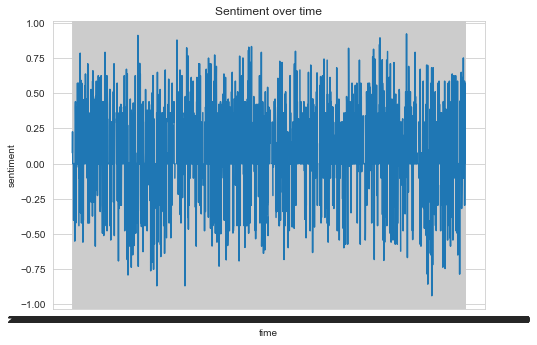

In [33]:
name_of_friend = input('Name of your friend: ')     # You can insert the name directly as a string on the next line instead
friend = df[df['sender_name'] == name_of_friend]
friend_x = friend['timestamp_ms']
friend_y = friend['sentiment']

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.plot(friend_x, friend_y)
ax.set_xlabel('time')
ax.set_ylabel('sentiment')
ax.set_title('Sentiment over time')

We can also make a plot with the `seaborn` library.

In [9]:
import seaborn as sns 

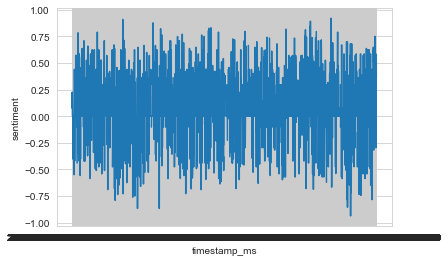

In [519]:
dist = sns.lineplot(x='timestamp_ms', y='sentiment', data= friend)

Or, we can use `plotly` and `cufflinks` to create an interactive plot.

In [10]:
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

import cufflinks as cf

init_notebook_mode(connected=True)
cf.go_offline()

In [38]:
my_name = input('My name is ')

My name is Denis Rozhnov


In [39]:
friend = df[df['sender_name'] == my_name]
#sorted_friend = friend.sort_values(['date', 'time'])
friend.iplot(kind='line', x='timestamp_ms', y='sentiment')

### Other plots - majors, residence and sentiments

We can plot the sentiment variations for messages sent by students of different majors, and colored by the sender's residence.

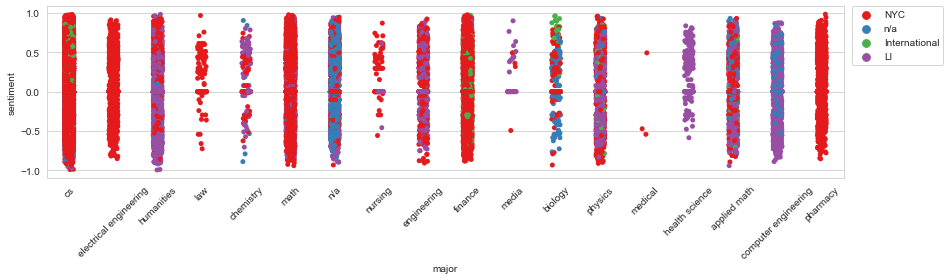

In [89]:
plt.figure(figsize= (12, 4))
plt.xticks(rotation = 45)
sns.stripplot(x='major', y='sentiment', data=df, jitter=True, hue='lives in', palette='Set1')
plt.tight_layout()
plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)

Thus we can see that I have received facebook messages from only those electrical engineers who live in NYC, and from only those computer engineers who live on Long Island.

We can also see that apart from a single message sent by a NYC resident, the most joyless applied mathematicians are Long Islanders. We can also see that international students are the most cheerful biologists.

Let's identify the single depressing message sent by an applied mathematician from NYC. (This was not in response to me)

In [23]:
ams_nyc = df[(df['major'] == 'applied math') & (df['lives in'] == 'NYC')]
ams_nyc[ams_nyc['sentiment'] == ams_nyc['sentiment'].min()]['content']

715    For I said no stupid shit to be ridiculed
Name: content, dtype: object

We also notice that Long Islanders are the most depressed computer scientists, and appear to send the most depressing messages in general. I will dismiss the results for media majors due to an insufficient sample size of messages (the Long Islander who sent them is a very cheerful guy).

However, there is the potential of the long island data points to be covered by data points of other residence areas.

We can test this out by simply plotting the sentiment of only Long Islanders across different college majors.

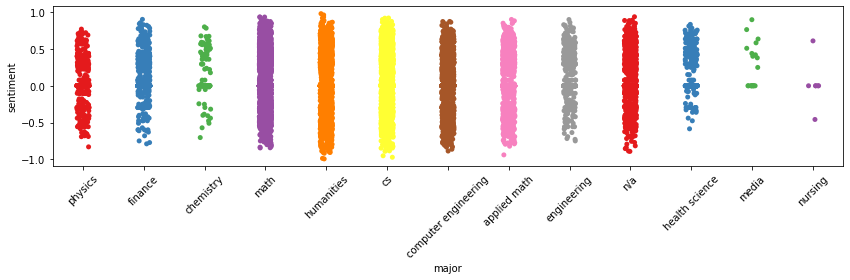

In [24]:
plt.figure(figsize= (12, 4))
plt.xticks(rotation = 45)
sns.stripplot(x='major', y='sentiment', data=df[df['lives in'] == 'LI'], jitter=True, palette='Set1')
plt.tight_layout()

We can see that many of the cheerful messages from Long Island were indeed hidden by messages from other locations. We may want to see how Long Islander messages compare with messages from other locations.

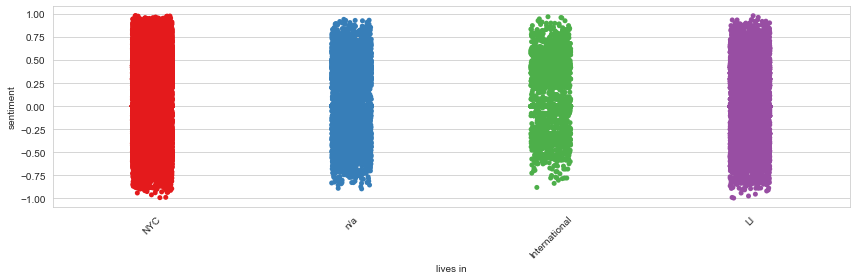

In [12]:
sns.set_style("whitegrid")
plt.figure(figsize= (12, 4))
plt.xticks(rotation = 45)
sns.stripplot(x='lives in', y='sentiment', data=df, jitter=True, palette='Set1')
plt.tight_layout()

It appears that Long Islanders display slightly less positive messaging behavior at their happiest, but also slightly more positive messaging behavior at worst.

This might be attributed to the fact that I have sent and recieved fewer messages to and from Long Islanders, as you can see below.

In [26]:
df.groupby('lives in').count()['content']

lives in
International      6662
LI                31593
NYC              102686
n/a               14048
Name: content, dtype: int64

We can also plot sentiments by major, splitting (`dodge`) the plot by residence. This now shows us that the earlier observation about joyless Long Island applied mathematicians is not accurate, as the Long Islanders have roughly the same range of sentiments as the NYC residents.

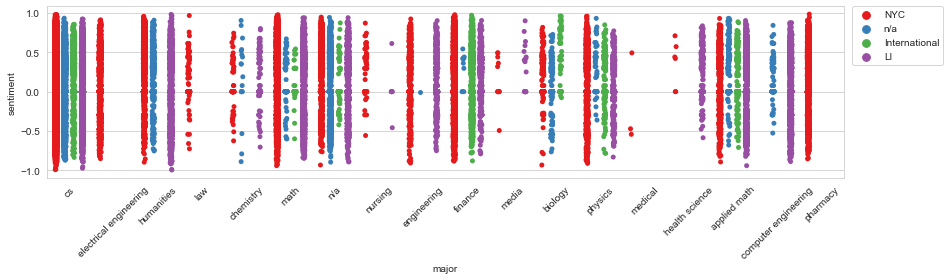

In [27]:
plt.figure(figsize= (12, 4))
plt.xticks(rotation = 45)
strip = sns.stripplot(x='major', y='sentiment', data=df, jitter=True, hue='lives in', palette='Set1', dodge=True)
plt.tight_layout()
plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)

We can plot line graphs to indicate the average mood of Long Islanders, NYC residents and International students over the years and months.

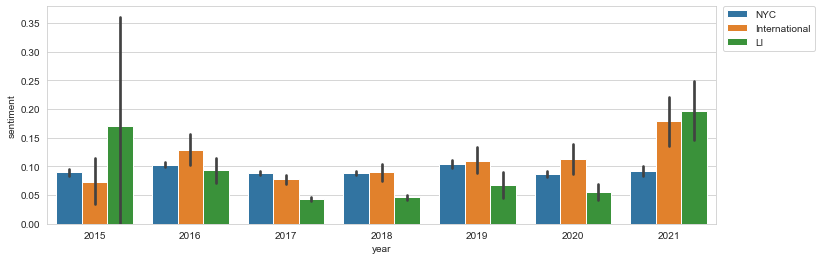

In [28]:
plt.figure(figsize=(12,4))
sns.barplot(x='year', y='sentiment', data=df[df['lives in'] != 'n/a'], hue='lives in')
plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)

In [29]:
df.groupby('year').count()['content']

year
2015     8890
2016    14553
2017    52715
2018    40611
2019     9021
2020    25435
2021     3764
Name: content, dtype: int64

Below the bar graph I display the total number of outgoing and incoming messages on my account per year. Keep in mind that I have the least amount of messages sent in 2021 (it is April 2021 at the time of this writing).

We still notice some trends. It seems that Long Islanders have experienced a significant improvement of sentiment this year, while this is not true of New Yorkers. In fact, this is the second year (and in a row) that the Long Island sentiment is higher than that of NYC. Possibly this is because many Long Islanders whom I know had to commute to college, but since this is no longer required, their overall attitude has improved. Perhaps as well Long Islanders are no longer tempted to visit NYC as much as they were before the pandemic, so there might have been a significant shift in routines and activities.

Let's look at the sentiments over the course of last year to make sure.

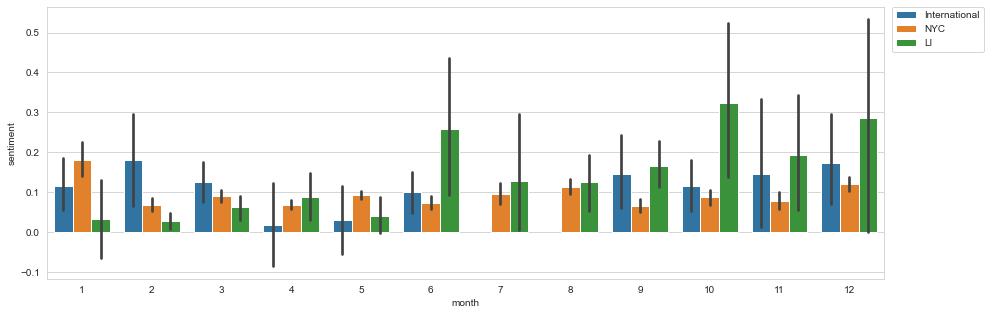

In [30]:
plt.figure(figsize=(15,5))
sns.barplot(x='month', y='sentiment', data=df[(df['year'] == 2020) & (df['lives in'] != 'n/a')], hue='lives in')
plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)

It appears that the mood for Long Islanders was indeed generally higher after May, when the spring semester ended. Just to be sure, let us check the sentiment trend for Long Islanders during the years up to 2019.

<AxesSubplot:xlabel='month', ylabel='sentiment'>

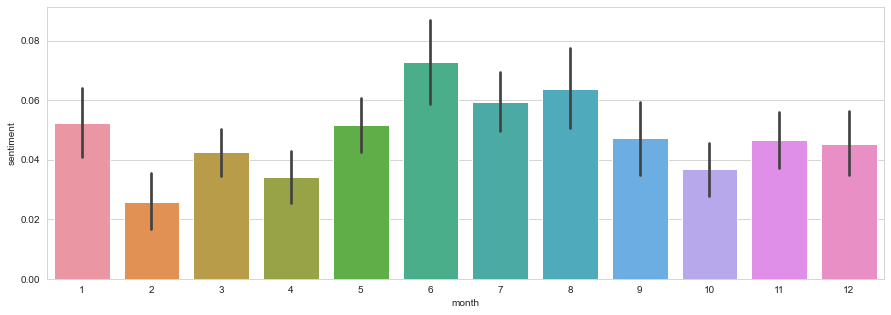

In [31]:
plt.figure(figsize=(15,5))
sns.barplot(x='month', y='sentiment', data=df[(df['year'] != 2020) & (df['year'] != 2021) & (df['lives in'] == 'LI')])

The overal Long Island mood last year was significantly lower than it was on average over the prior five years. However, the mood was significantly higher during the second half of last year than it was during the first half. Long Islanders were clearly not happy about staying at home, but they were content with no longer needing to commute. This was confirmed in conversations.

There was, however, a significantly lower than average January mood amongst Long Islanders, so I looked at how many messages were sent between me and Long Islanders throughout last year.

In [32]:
last = df[(df['lives in'] == 'LI') & (df['year'] == 2020)]
last.groupby('month').count()['content']

month
1      47
2     782
3     407
4      91
5     192
6      10
7       7
8      56
9      73
10      7
11     19
12      8
Name: content, dtype: int64

These are not a lot of messages, so the results are not telling. Compare this to the average number of messages for the prior years.

In [33]:
prior = df[(df['lives in'] == 'LI') & (df['year'] != 2020) & (df['year'] != 2021)]
prior_nums = prior.groupby('month').count()['content']

for i in range(1, 13):
    if i < 5:
        prior_nums[i] /= 4
    else:
        prior_nums[i] /= 5

prior_nums

month
1     557
2     709
3     911
4     661
5     546
6     261
7     427
8     266
9     345
10    682
11    579
12    576
Name: content, dtype: int64

I have clearly not communicated with Long Islanders a lot on facebook messenger last year, so the sentiment results are likely misleading for that year. The results for NYC residents, however, are consistent. They also follow their characteristic (prior average) pattern, which is shown below.

Note, however, that the NYC resident mood was significantly below its average in April and May (campuses were closed in mid-March). These were also the months when I had the most interaction with NYC residents on facebook messenger.

This is possibly because NYC residents appreciated the change in setting when they went to a rural campus. In addition to that, NYC residents were in quarantine, which affected their mood.

<AxesSubplot:xlabel='month', ylabel='sentiment'>

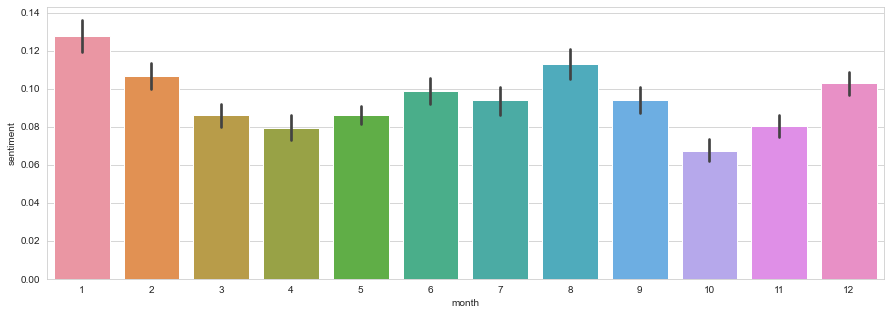

In [34]:
plt.figure(figsize=(15,5))
sns.barplot(x='month', y='sentiment', data=df[(df['year'] != 2020) & (df['year'] != 2021) & (df['lives in'] == 'NYC')])

### Years in college and sentiments

Let's now explore how a student's standing (freshman through senior) affects their attitude.

Let us first determine the student's standing at the time when each message was sent. We are using our knowledge of the year at which the student entered college.

In [13]:
def standing(date):                          # Computes the number of years of college that the student has completed
    year =  int(str(date)[:4])
    month = int(str(date)[5:7])
    if month < 6:                            # Anything before June counts as the previous academic year
        year -= 1
    return year

In [14]:
from datetime import date

def yearToInt(year):
    if year == 'n/a':
        return date.today().year + 2                     # Ensures taht the date is two years ahead of today
    return int(year)

In [15]:
# Find the difference between the date of the message and the date entered college.
# Difference is less than -1 if date of college is 'n/a'

df['academic standing'] = df['date'].apply(lambda date: standing(date)) - df['entered_college'].apply(lambda year: yearToInt(year))

Now we can convert the academic_standing from a number to a title of standing (freshman, sophomore, ...)

In [16]:
standingTitle = {
    0: 'Freshman',
    1: 'Sophomore',
    2: 'Junior',
    3: 'Senior',
    4: 'Post-senior'
}


def valueToStanding(value):
    if type(value) != int:
        return value
    if value == -1:
        return 'High school senior'
    if value < 0:
        return 'n/a'
    if value >= 5:
        return 'Graduated'
    return standingTitle[value]

In [17]:
df['academic standing'] = df['academic standing'].apply(lambda value: valueToStanding(value))

Now let us see how the standing of the student affects the mood of the student. First let's get a complete overview for the entire duration of my messaging history. We illustrate it in the box-and-whisker plot below.

<AxesSubplot:xlabel='academic standing', ylabel='sentiment'>

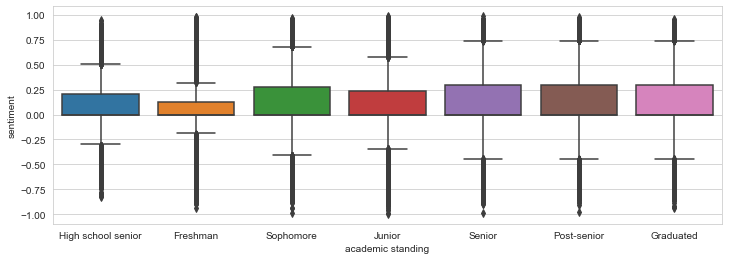

In [21]:
plt.figure(figsize=(12,4))
sns.boxplot(x='academic standing', y='sentiment', data=df[df['academic standing'] != 'n/a'])

These are averaged values. They might not be as valuable; there is more information that can be extracted due to the lifestyle changes around COVID.

Let us see what the distribution of messages for each of the academic standings is across the years.

In [41]:
df.groupby(['academic standing', 'year']).count()['content']

academic standing   year
Freshman            2015     5297
                    2016     4402
                    2017    11140
                    2018     4088
                    2019      210
                    2020       14
Graduated           2017       19
                    2018      374
                    2019      249
                    2020     5135
                    2021     2272
High school senior  2015     3423
                    2016       84
Junior              2015       65
                    2016      805
                    2017    21620
                    2018    17302
                    2019     1965
                    2020     4636
                    2021       19
Post-senior         2016       58
                    2017      461
                    2018     1552
                    2019     2630
                    2020     8921
                    2021     1034
Senior              2015       21
                    2016      740
                    201

<AxesSubplot:xlabel='year', ylabel='academic standing'>

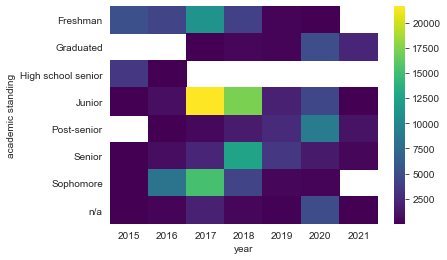

In [42]:
standVsYear = df.groupby(['academic standing', 'year']).count()['content'].unstack()
sns.heatmap(standVsYear, cmap='viridis')

Perhaps this is easier to see with a bar graph.

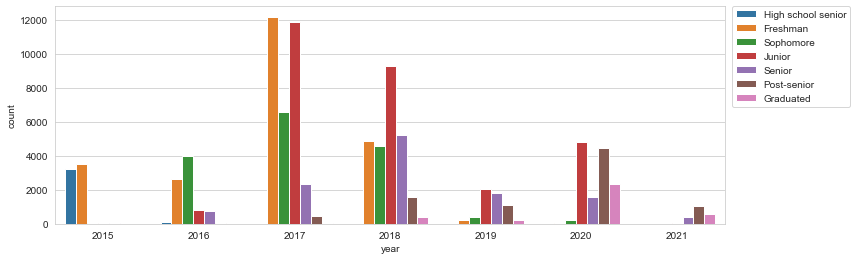

In [43]:
plt.figure(figsize=(12,4))
sns.countplot(x='year', data=df[(df['sender_name'] != my_name) & (df['academic standing'] != 'n/a')], hue='academic standing')
plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)

In this bar graph I have also filtered out the messages sent by me. We can see how I am messaged by an increasingly older audience as time goes on. This shift would be much more noticeable when we plot the year agains the number of first messages that we have recieved from each user, hued by the user's standing.

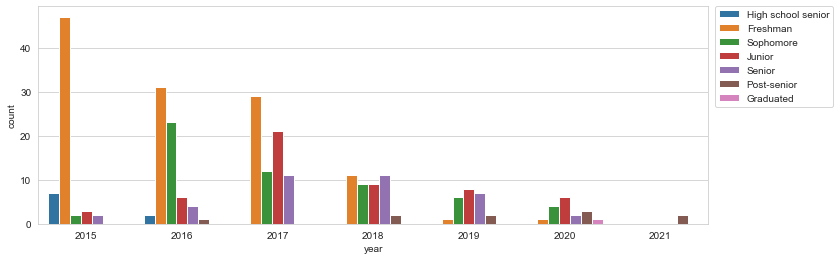

In [18]:
names = {}
def alreadySent(name):
    if name in names:
        return False
    names[name] = 'Found'
    return True
    
df['first message'] = df['sender_name'].apply(lambda name: alreadySent(name))

'''newCounts = df.groupby(['first message', 'year']).count()['content']
firstCounts = newCounts[1]
firstCounts'''

plt.figure(figsize=(12,4))
sns.countplot(x='year', data=df[(df['sender_name'] != my_name) & (df['first message'] == True) & (df['academic standing'] != 'n/a')], hue='academic standing')
plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)

Indeed we can observe a steady decline in the number of freshman who begin to talk to me over time. There is a slight increase in the number of non-freshman whom I communicate with from 2015 to 2016, in part because in 2015 I knew upperclassmen exclusively from the Mathematics Society at Baruch College and from the Society of Physics Students at NYU.

The number of sophomores who message me first decreases steadily after 2016, as does the number of juniors after 2017. A similar trend can be noticed with senoirs after 2018.

Each of these categories experiences an increase before it peaks, because as I progressed through college, I met more students older than myself. After peaking, these values experience a significant (a third to a half) decrease, after which the decrease becomes less pronounced.

It is also notable that the maximal values of the categories decreases (more maximum freshman than sophomores for instance). The spike in freshmen in 2015 can be attributed to my adding many students from my high school to my facebook account. While I have communicated with a few of my closest friends before high school ended, I assume that many of them were placed into the freshman category of this plot because I have created the accound in May, just one month ahead of the June transition to counting us as freshmen.

I can also look at how many first messages I have recieved from students of my own academic standing each year.

In [19]:
firstMessages = df[(df['sender_name'] != my_name) & (df['first message'] == True) & (df['academic standing'] != 'n/a')]
myYear = int(df[df['sender_name'] == my_name]['entered_college'].iloc[0])

firstMessages['relative standing'] = firstMessages['entered_college'].apply(lambda entered: myYear - int(entered))

<AxesSubplot:xlabel='year', ylabel='count'>

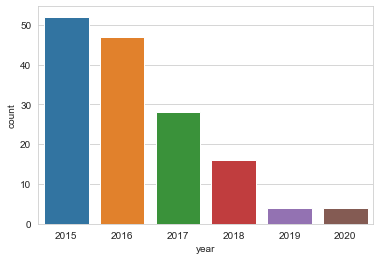

In [97]:
sns.countplot(x='year', data=firstMessages[firstMessages['relative standing'] == 0])

It appears that as time went on, I met fewer and fewer students of my academic standing.

This is reasonable, because in 2015 I mostly knew my peers. In 2016 and 2017 I was taking mathematics courses where I met many upperclassmen. In 2017 I transferred to a different school and started taking computer science classes, where I met many lowerclassmen, as well as incoming freshmen at my dorm. In 2020 I simply did not meet many new people.

Let's see the distribution of new messages by relative standing.

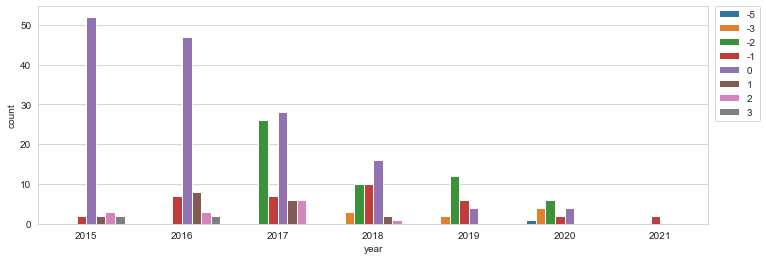

In [26]:
plt.figure(figsize=(12,4))
sns.countplot(x='year', data=firstMessages, hue='relative standing')
plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)

The positive values here indicate the number of years by which the student is older than me. Surprisingly, I have not started many new conversations with younger students, but rather had more conversations opened by students older than me.

Now I wanted to see how many messages were sent to me by relative standing.

In [20]:
df['relative standing'] = df['entered_college'].apply(lambda entered: myYear - int(entered) if (entered != 'n/a') else 'n/a')

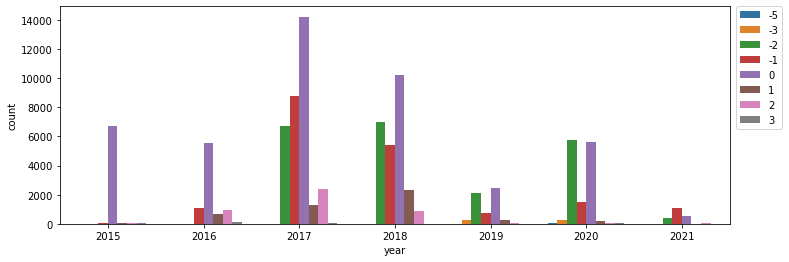

In [20]:
plt.figure(figsize=(12,4))
sns.countplot(x='year', data=df[(df['relative standing'] != 'n/a') & (df['sender_name'] != my_name)], hue='relative standing')
plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)

I have indeed been consistently message mostly by students of my age. This means that the information that I can gather about my own age class is statistically the most accurate. However, the substantial amount of information available about students of the two years younger than mine could allow me to identify certain trends, particularly between 2017 and last year.

The spike of activity in 2017 is due to my joining a very active group chat. The spike of activity among students two years younger than me in 2020 is also due to a group chat.

My decrease in messaging activity in 2019 that can be observed throughout these graphs is due to me being busier that year, as well as my getting a phone in the fall of 2018 - therefore 2019 was my first full year of texting some people whom I used to message on facebook.

We can now look at the overall sentiments exhibited by students of different academic standings across the years. 

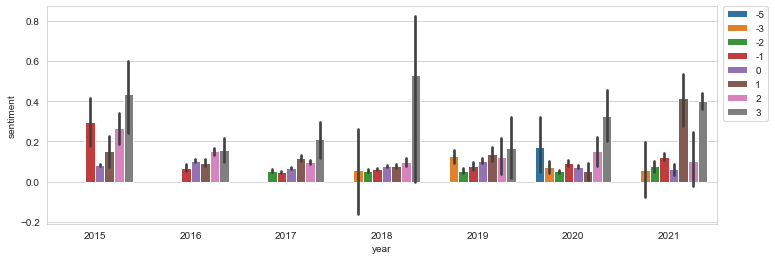

In [50]:
plt.figure(figsize=(12,4))
sns.barplot(x='year', y='sentiment', data=df[(df['relative standing'] != 'n/a') & (df['sender_name'] != my_name)], hue='relative standing')
plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)

We can see that students of my standing are continuously in a better mood than students of the two years that follow. Though this trend has been broken last year, it is also notable that I have much fewer observations of students a year younger than me from last year, and most of these students were seniors graduating into the pandemic. During the current year, I do not have enough messages to draw reasonable conclusions about sentiments.

It is interesting to see that the relative sentiments are determined not by the academic standing but by the relative age group. Perhaps this is because I have generally met older students earlier in my academic career, and our style of communication has remained the same.

In this case, students who are a year younger than me would provide the best picture of student moods, since the distribution of first messages from them is spread most evenly. However, there is still a problem with that reasoning - I do not have many total messages from them, except for in the years 2017 and 2018.

Let's make a graph of average moods of students by academic standing across the years, showing the average moods of only those students whom I began to communicate with in the given year. Then we can see if the general mood changed, without accounting for the students who have already developed a distinct communication style with me.

In [21]:
                            # fixHS changes High school senior to Freshman, since the seniors became freshman a month after I created my account
fixHS = df
fixHS['academic standing'] = fixHS['academic standing'].apply(lambda standing: 'Freshman' if (standing == 'High school senior') else standing)

                            # FirstYear identifies the sender_name and the academic standing for every first message

firstYear = fixHS[(fixHS['first message'] == True)][['sender_name', 'academic standing']]

                            # firsts is a dictionary keyed by name containing the academic standing at which the student was met
firsts = {}
for i in range(len(firstYear)):
    row = firstYear.iloc[i]
    firsts[row['sender_name']] = row['academic standing']

                            # fsm (first standing messages_ stores messages sent while user was of original academic standing
    
fsm = df[df['academic standing'] == df['sender_name'].apply(lambda name: firsts[name])]

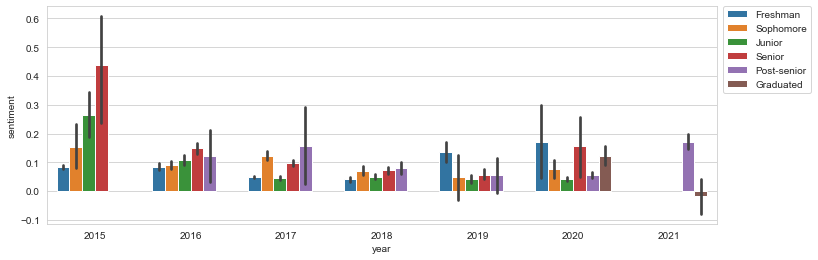

In [101]:
plt.figure(figsize=(12,4))
sns.barplot(x='year', y='sentiment', data=fsm[(fsm['academic standing'] != 'n/a') & (fsm['sender_name'] != my_name)], hue='academic standing')
plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)

Let us also plot the number of messages on which these observations are based.

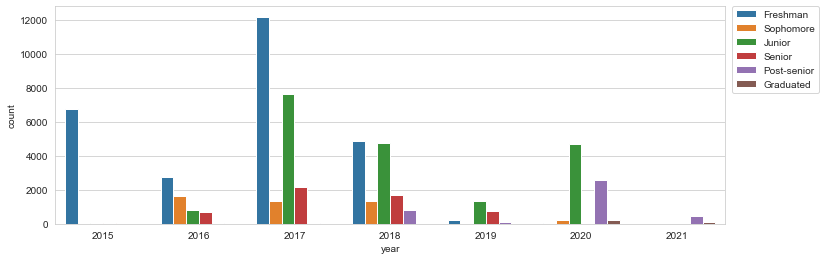

In [53]:
plt.figure(figsize=(12,4))
sns.countplot(x='year', data=fsm[(fsm['academic standing'] != 'n/a') & (fsm['sender_name'] != my_name)], hue='academic standing')
plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)

From this we can tell that I have mostly communicated with new freshmen and juniors in 2017 and 2018, and I communicated a lot with freshmen in 2015 and juniors last year, so these are the most reliable sources of information.

We can observe that freshman sentiments have dropped since 2015, and that junior sentiments have remained consistent, although experiencing a slight decrease last year. Perhaps the freshman data gathered from students before they actually went to college was significantly higher than it was for freshman students currently in collge.

For better insight, let us see the same graphs but broken down not by year, but by semester. We will now count the fall semester to start in september, allowing summer sentiments to be attributed to the previous spring, therefore discounting the pre-college summer posts from counting towards the freshman fall sentiments. First I will display the sentiment plot.

In [22]:
df['semester'] = df['month'].apply(lambda month: 'Fall' if (month >= 9) else 'Spring')
df['semester'] = df['semester'] + ' ' + df['year'].apply(str)

                                    # Let's redefine fsm with updated df
fsm = df[df['academic standing'] == df['sender_name'].apply(lambda name: firsts[name])]

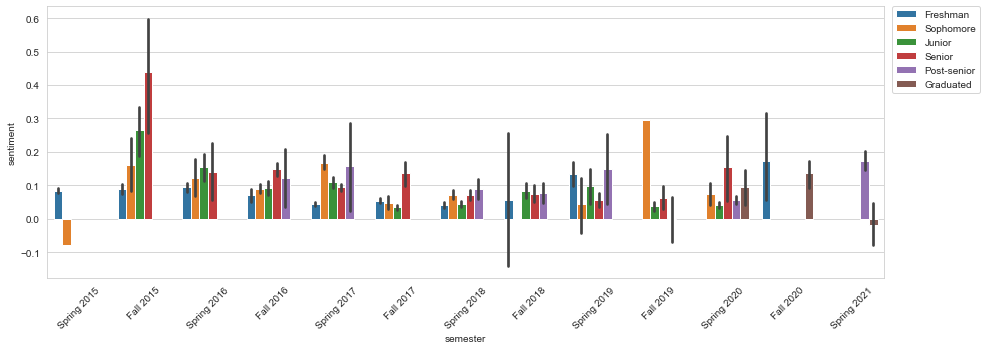

In [103]:
plt.figure(figsize=(15,5))
plt.xticks(rotation = 45)
sns.barplot(x='semester', y='sentiment', data=fsm[(fsm['academic standing'] != 'n/a') & (fsm['sender_name'] != my_name)], hue='academic standing')
plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)

Now let's display the count plot.

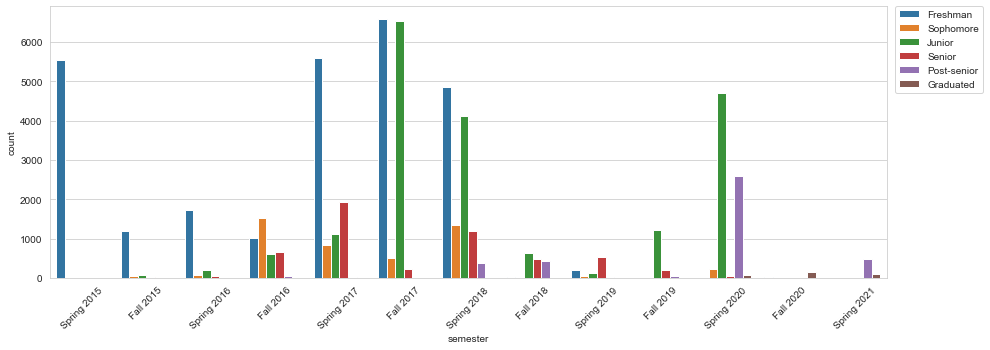

In [104]:
plt.figure(figsize=(15,5))
plt.xticks(rotation = 45)
sns.countplot(x='semester', data=fsm[(fsm['academic standing'] != 'n/a') & (fsm['sender_name'] != my_name)], hue='academic standing')
plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)

Again, we see that out most reliable data comes from
* freshmen in 2015, 2017, and in the spring of 2018
* juniors in fall 2017, spring 2018, and spring 2020

The post-senior and graduates category is trickier to analyze, because it can be split into the employed and the unemployed. There is more variety in activities and mindsets because of the uncharted lifestyles of post-seniors and graduates. The post-senior category includes those students who have completed four years in college under a year ago.

These graphs confirm our earlier observations that freshman attitudes have declined after 2015, while junior attitudes appear to have remained stably low.

Keep in mind that most of the students whom I knew before Fall 2017 were students at Baruch College and New York University, while the students whom I messaged from Fall 2017 and onwards were students from Stony Brook University. Perhaps I should compare attitudes of students from those schools by semester.

Below is a bar plot indicating the number of messages sent from students from different schools by semester. We can tell that the most useful information about sentiments can be found from

* Spring 2015 - Brooklyn Tech  - High school seniors
* Fall 2016   - Baruch         - Freshmen and sophomores
* Spring 2017 - Baruch         - Freshmen and some seniors
* Fall 2017   - Stony Brook    - Freshmen and juniors
* Spring 2018 - Stony Brook    - Freshmen and juniors
* Spring 2020 - Stony Brook    - Juniors and post-seniors

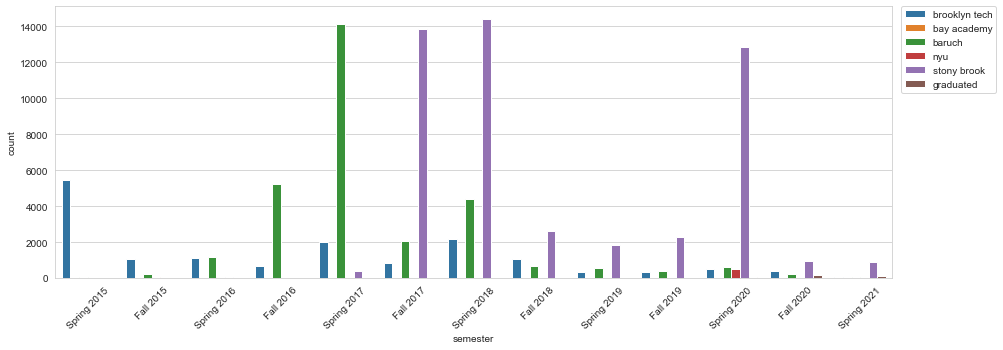

In [105]:
plt.figure(figsize=(15,5))
plt.xticks(rotation = 45)
sns.countplot(x='semester', data=df[((df['meeting place'] != 'n/a') & (df['sender_name'] != my_name))], hue='meeting place')
plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)

### Text properties

Now we will analyze data about the messages themselves, other than their sentiments.

First let's look at how many messages I have recieved from students of different majors. This might not alone be a good indication of how much different majors have communicated with me. I want the total amount of content that was sent to me. The more proper way of computing this is to multiply the vector of messages by major times the vector of average message length by major.

You can replace `major` with any other feature that you are interested in.

In [23]:
df['length'] = df['content'].apply(lambda message: len(str(message).split()))

In [107]:
number = df.groupby('major').count()['sender_name']
length = df.groupby('major').mean()['length']

total = number*length
total
#df.sort_values('length')

major
applied math               27647.0
biology                     3799.0
chemistry                   1588.0
computer engineering       23200.0
cs                        660567.0
electrical engineering     12174.0
engineering                12437.0
finance                    82082.0
health science              1829.0
humanities                 54093.0
law                          781.0
math                      110611.0
media                        150.0
medical                       10.0
n/a                        32391.0
nursing                      429.0
pharmacy                   16885.0
physics                    19763.0
dtype: float64

Let's see how length of message relates to the sentiment of the message.

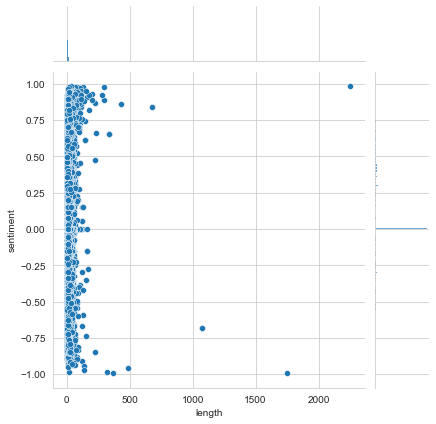

In [63]:
sns.jointplot(x='length', y='sentiment', data=df)

It appears that most messages are under around 100 words long. We notice that as the messages get longer, they tend to become much more apparently positive or negative. Let us see if we can identify a linear relation between length in words and sentiment of messages - we will disregard outliers using the interquartile range proximity rule.

In [37]:
firstQuantile = df.length.quantile(0.25)
thirdQuantile = df.length.quantile(0.75)

interQuantileRange = thirdQuantile - firstQuantile

upperBoundary = thirdQuantile + 1.5*interQuantileRange

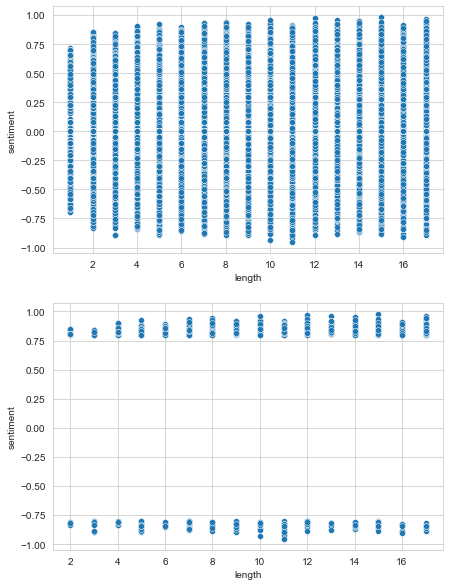

In [65]:
#sns.jointplot(x='length', y='sentiment', data=df[df['length'] <= upperBoundary])
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(7, 10), sharey=True)
sns.jointplot(x='length', y='sentiment', data=df[df['length'] <= upperBoundary], ax=ax1)
sns.jointplot(x='length', y='sentiment', data=df[(df['length'] <= upperBoundary) & ((df['sentiment'] > 0.8) | (df['sentiment'] < -0.8))], ax=ax2)
plt.close(2)
plt.close(3)

The first plot shows all messages of non-outlier length. We cannot identify a linear pattern here. We also do not observe the bifurcation behavior that we mentioned earlier. Perhaps we cannot observe the bifurcation because we cannot clearly see the density of points on the plot.

The second plot shows only the tempermental messages. We cannot clearly observe the bifircation behavior here either. It is possible that we cannot see it because we do not accurately see the density of these points on the graph.

Let us see if this behavior becomes apparent regardless of the extreme outliers.

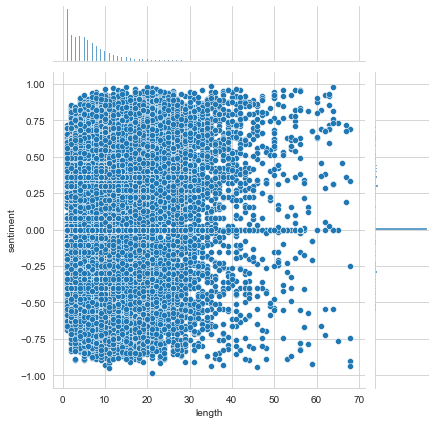

In [66]:
upperBoundary = thirdQuantile + 10*interQuantileRange

sns.jointplot(x='length', y='sentiment', data=df[df['length'] <= upperBoundary])

The bifurcation becomes more apparent here. As the message length increases, the the density of messages closer to neutral sentiment appears to decrease relative to the density of messages with extreme sentiments.

Interestingly, there appears to be a significant number of entirely neutral messages appearing of different lengths. Let's see if these patterns continue.

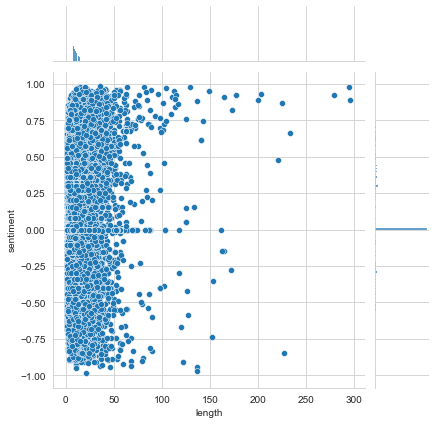

In [67]:
upperBoundary = thirdQuantile + 50*interQuantileRange

sns.jointplot(x='length', y='sentiment', data=df[df['length'] <= upperBoundary])

The bifurcation pattern appears to persist, although the neutral messages are curbed at a length of around 160.

Let us rotate this distribution by 90 degrees and see if we can fit a quadratic regression line to it. We will not show the data points to avoid cluttering the graph, as well as to allow seaborn to select the optimal y-range for the graph.

<AxesSubplot:xlabel='sentiment', ylabel='length'>

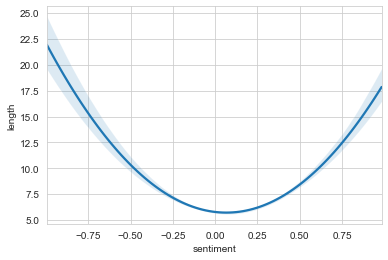

In [68]:
sns.regplot(x='sentiment', y='length', data=df, order=2, scatter=False)

We can also find the coefficients of the polynomial.

In [24]:
import numpy as np

In [109]:
df_clean = df[(df['length'].notnull()) & (df['sentiment'].notnull())]
coeffs = np.polyfit(np.array(df_clean['sentiment']), np.array(df_clean['length']), 2)

print('The function is: y = (' + str(coeffs[0]) + ' * x^2) + (' + str(coeffs[1]) + ' * x) + ' + str(coeffs[2]))

The function is: y = (14.406402645622087 * x^2) + (-1.9017683633833278 * x) + 5.772839802775384


If you consider messages that are of length greater than 50, this bifurcation becomes even more obvious.

<AxesSubplot:xlabel='sentiment', ylabel='length'>

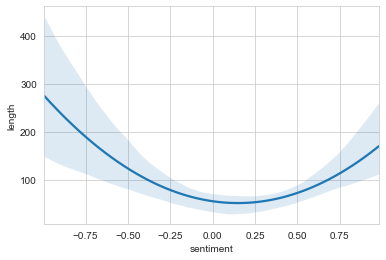

In [71]:
sns.regplot(x='sentiment', y='length', data=df[df['length'] > 50], order=2, scatter=False)

To a lesser extent, this bifurcation can be noticed even among messages of length less than 50.

<AxesSubplot:xlabel='sentiment', ylabel='length'>

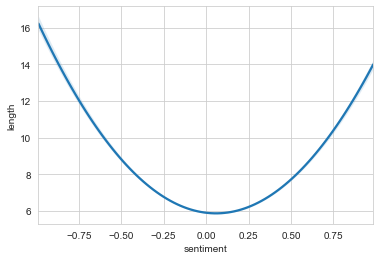

In [72]:
sns.regplot(x='sentiment', y='length', data=df[df['length'] < 50], order=2, scatter=False)

This trend is also clearly apparent in messages of length 17 and below, which we could not see on the jointplot because of our inability to recognize the density of points.

<AxesSubplot:xlabel='sentiment', ylabel='length'>

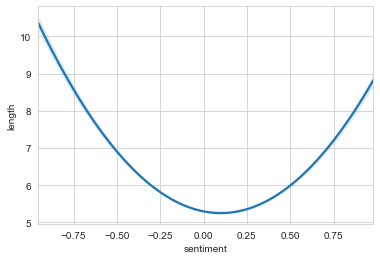

In [73]:
sns.regplot(x='sentiment', y='length', data=df[df['length'] <= 17], order=2, scatter=False)

The same trend can be noticed with messages that are of length less than 5.

<AxesSubplot:xlabel='sentiment', ylabel='length'>

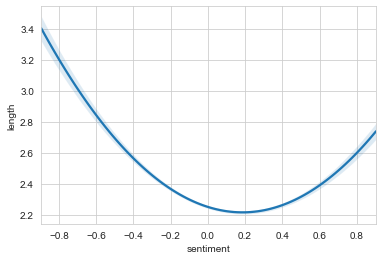

In [74]:
sns.regplot(x='sentiment', y='length', data=df[df['length'] < 5], order=2, scatter=False)

So far we have been looking at how sentiment varies with length for specific length ranges. We have noticed a trend: we can expect more sentimentally extreme messages to be longer than more neutral messages. However, we would could also expect fewer extreme messages on which we can base our observations. There could hypothetically be a lot of very long neutral messages which are balanced by many more short neutral messages.

Therefore, while we see that we can expect a more tempermental message to be longer, we do not know for certain that longer messages are more tempermental from these graphs. Therefore, a much more illuminating graph would show the percentage of highly tempermental (absolute value of sentiment greater than 0.8) messages by message length.

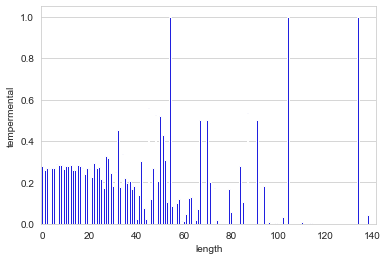

In [110]:
countLengths = df.groupby('length').count()['timestamp_ms']
countExtremes = df[(df['sentiment'] > 0.8) | (df['sentiment'] < -0.8)].groupby('length').count()['timestamp_ms']

                                        # Find the percentage of extreme tempermental values for each length
ratio = countExtremes / countLengths
ratio.replace(np.nan, 0.01)             # Replace values where no extremes found with visible number instead of 0 (to illustrate existence)

display = pd.DataFrame()
display['length'] = df['length']
display['tempermental'] = ratio

sns.barplot(x='length', y='tempermental', data=display, ci=None, color='blue')

import matplotlib.ticker as ticker
ax = plt.gca()
ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))
ax.xaxis.set_major_locator(ticker.MultipleLocator(base=20))
plt.show()

This confirms our observation that longer messages tend to be more tempermental.

Let us see what the neutral messages are. in particular, let's look at what the longer messages with close to neural value are.

In [76]:
#neutral = df[(df['sentiment'] == 0) & (df['length'] < 100) & (df['length'] > 20)].sort_values('length')
closeToNeutral = df[(df['length'] > 100) & (df['sentiment'] < 0.25) & (df['sentiment'] > -0.25)]
closeToNeutral['content']

81       In this course, the primary goal is to study t...
245      // Generating random strings\n#include <iostre...
207      // Generating random strings\n#include <iostre...
504      def robot_competition(robot1, robot2):\n    in...
492      # Part II\ndef updown_decrypt(encrypted, num_r...
482      def search_car(query, dealerships):  # SELECT ...
161      def search_car(query, dealerships):  # SELECT ...
451      def decimal_to_fixed_point(value):\n    split ...
426      ddef decimal_to_fixed_point(value):\n\n    par...
232      Denis,\n\nI used some software that flags subm...
11019    Denis,\n\nI used some software that flags subm...
2944     Inspect input data, test harness. The test cas...
Name: content, dtype: object

We can see that many of these messages are simply Python and C++ code. We can find out what percentage of these messages is code. It turns out that half of the long, close to neutral messages are in fact code.

In [77]:
longNeutrals = len(closeToNeutral)

codeMessages = closeToNeutral[(closeToNeutral['content'].apply(lambda cont: True if (cont.find('return') != -1) else False)) & (closeToNeutral['content'].apply(lambda cont: True if (cont.find('def ') != -1) else False))]

codeNeutrals = len(codeMessages)
codeNeutrals/longNeutrals

0.5

### Time Series

We can try to further explore our data by considering time series of sentiments and message lengths.

Let's first look at your own sentiment over time graph. Here I arrange sentiments by 

<AxesSubplot:xlabel='date'>

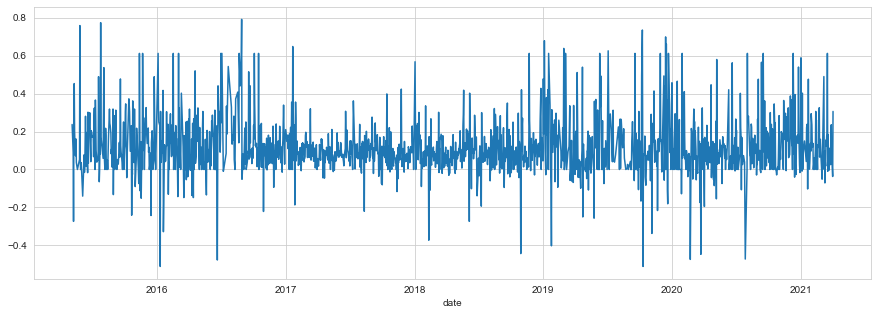

In [111]:
my_sentiments = df[df['sender_name'] == my_name]
my_sentiments = my_sentiments.groupby('date').mean()

plt.figure(figsize=(15,5))
my_sentiments['sentiment'].plot()

Now we can represent this data via a rolling window to get the averages for sentiment over a time period.

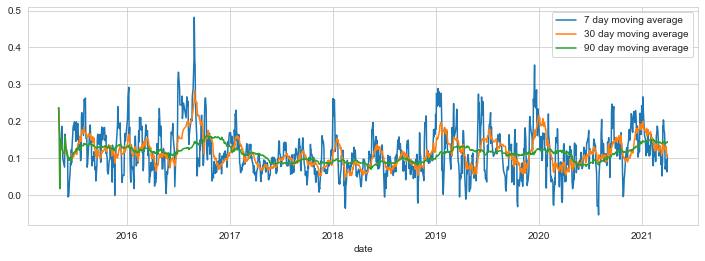

In [79]:
plt.figure(figsize=(12,4))
weekly =  my_sentiments['sentiment'].loc[:].rolling(window=7, min_periods=1).mean().plot(label='7 day moving average')
monthly = my_sentiments['sentiment'].loc[:].rolling(window=30, min_periods=1).mean().plot(label='30 day moving average')
quarter_yearly = my_sentiments['sentiment'].loc[:].rolling(window=120, min_periods=1).mean().plot(label='90 day moving average')
plt.legend()

Text(0.5, 1.0, 'Weekly rolling average of my sentiment')

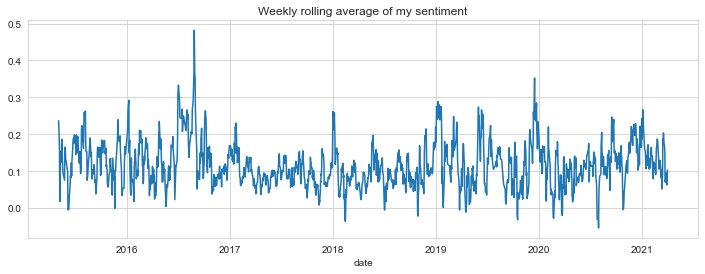

In [80]:
plt.figure(figsize=(12,4))
my_sentiments['sentiment'].loc[:].rolling(window=7, min_periods=1).mean().plot()
plt.title('Weekly rolling average of my sentiment')

Text(0.5, 1.0, 'Monthly rolling average of my sentiment')

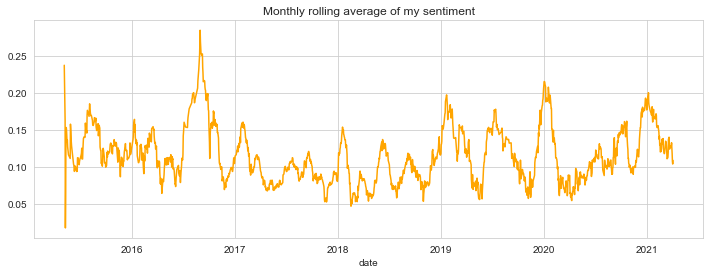

In [81]:
plt.figure(figsize=(12,4))
my_sentiments['sentiment'].loc[:].rolling(window=30, min_periods=1).mean().plot(color='orange')
plt.title('Monthly rolling average of my sentiment')

Text(0.5, 1.0, 'Semester-long rolling average of my sentiment')

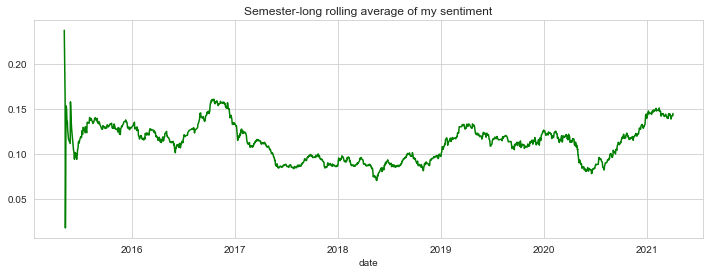

In [82]:
plt.figure(figsize=(12,4))
my_sentiments['sentiment'].loc[:].rolling(window=120, min_periods=1).mean().plot(color='green')
plt.title('Semester-long rolling average of my sentiment')

We can also identify trends throughout the years by looking at the semester-long rolling average of my sentiment.

Text(0.5, 1.0, 'Year-long rolling average of my sentiment')

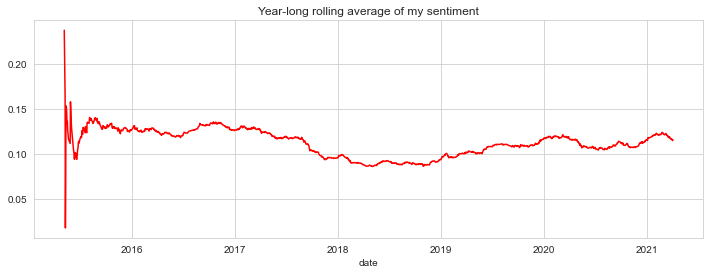

In [83]:
plt.figure(figsize=(12,4))
my_sentiments['sentiment'].loc[:].rolling(window=365, min_periods=1).mean().plot(color='red')
plt.title('Year-long rolling average of my sentiment')

There is a noticable dip in sentiment occurring in 2018.

Interestingly, we can see a similar pattern when considering the year-long rolling average of sentiments of everybody other than me.

Text(0.5, 1.0, "Year-long rolling average of everybody else's sentiment")

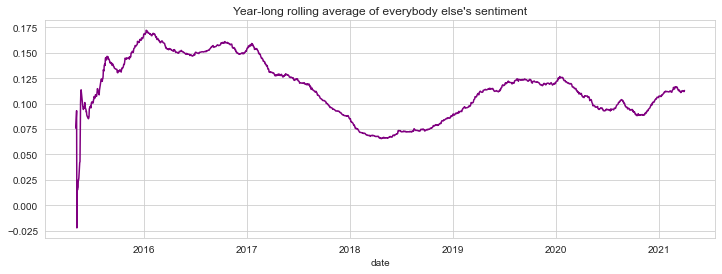

In [203]:
not_my_sentiments = df[df['sender_name'] != my_name]
not_my_sentiments = not_my_sentiments.groupby('date').mean()

plt.figure(figsize=(12,4))
not_my_sentiments['sentiment'].loc[:].rolling(window=365, min_periods=1).mean().plot(color='purple')
plt.title('Year-long rolling average of everybody else\'s sentiment')

### Identifying conversations

Now let's figure out how much time passed between pairs of messages. We will do this computation separately for each conversation, and then place the waiting time into the proper row in the `df` dataframe.

This might take some time to execute, so I coded it to make two beeping sounds at the end of execution to inform me of completion.

In [25]:
df.reset_index(inplace=True)               # Make index of df DataFrame unique, not only unique to conversation
del df['index']                            # Get rid of the old index column (now a regular column)

In [26]:
import winsound

chats = os.listdir('./conversations')
df['waited'] = df['sender_name']            # Copy column to create extra column of the proper length

for conversation in chats:                  # For each chat file
    
    convo = pd.DataFrame()
    convo['orig_index'] = df.index[df['conversation'] == conversation]
    convo['timestamp_ms'] = df[df['conversation'] == conversation]['timestamp_ms'].tolist()
    
    convo['shifted'] = convo['timestamp_ms'].shift(1)
    convo.sort_values('orig_index', inplace=True)
    
    convo['waited'] = pd.to_datetime(convo['timestamp_ms']) - pd.to_datetime(convo['shifted'])

    convoIndices = convo['orig_index'].tolist()
    
    for index in convoIndices:
        try:
            df['waited'].iloc[index] = convo[convo['orig_index'] == index]['waited'].iloc[0]
        except:
            df['waited'].iloc[index] = None
    
winsound.Beep(300, 1000)
winsound.Beep(300, 1000)

Now we will identify yet another column, called `new talk`, where we will determine that a new continuous conversation began inside of the chat file. We will say that if the message is the first in the chat, or if it is a response of over 12 hours in waiting time, then it is considered to be the start of a new conversation.

In [27]:
from datetime import timedelta

df['new talk'] = df['waited'].apply(lambda wait: True if ((wait >= timedelta(hours=12)) or (pd.isnull(wait))) else False)

This allows me to view all of the conversations that I had with others, ranked by the amount of distinct conversations that we had over the duration of the chat.

In [34]:
talks = df.groupby('conversation').sum().sort_values('new talk', ascending=False)['new talk']
pd.set_option('display.max_rows', 500)
talks                                      # I am not displaying my actual list, for privacy

## Saving the data

Let's save our dataframe `df` into a ***.csv*** file so that we could access if later.

We will call the file uncreatively but precisely, ***dataframe.csv***.

In [30]:
df.to_csv('./dataframe.csv')